In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def detect_lines(img, threshold1 = 50, threshold2 = 150, apertureSize = 3, minLineLength = 100, maxLineGap = 10):
    if not isinstance(img, np.ndarray):
        img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    # grayCon = cv2.addWeighted(gray, 2, gray, 0, 0)
    edges = cv2.Canny(gray, threshold1, threshold2, apertureSize=apertureSize) # detect edges
    lines = cv2.HoughLinesP(
                    edges,
                    1,
                    np.pi/180,
                    100,
                    minLineLength=minLineLength,
                    maxLineGap=maxLineGap,
            ) # detect lines

    lineList = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            linexy = [x1, y1, x2, y2]
            cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            lineList.append(linexy)
    return lineList

In [26]:
poolthing = cv2.resize(cv2.imread('lanes.png'), (cv2.imread('lanes.png').shape[1] // 2, cv2.imread('lanes.png').shape[0] // 2))
poolImgLanes = detect_lines(poolthing, 30, 100, 3, 229, 13)
poolImgLanes

[[1415, 531, 1676, 563],
 [514, 1047, 699, 738],
 [1441, 573, 1674, 618],
 [712, 1068, 765, 839],
 [557, 973, 706, 725]]

In [27]:
# imageIg = cv2.imread('lanes.png')
# g= cv2.cvtColor(imageIg, cv2.COLOR_BGR2GRAY)
# print(g[len(g)-1][1000:1500])
# plt.imshow(cv2.cvtColor(imageIg, cv2.COLOR_BGR2GRAY), cmap="gray", vmin=0, vmax=255)

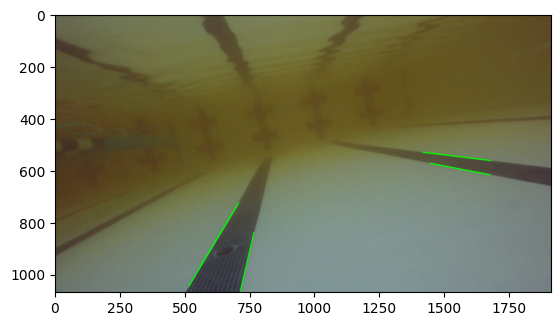

In [28]:
def draw_lines(img, lines, color = (0, 255, 0)):
    """Returns an image with specified lines drawn on
    args:
        img (image path or np.ndarray): image that lines are drawn on
        lines (list): list of points [[x1, y2, x2, y2], ...] of the lines being drawn
        color (tuple): (x, x, x)
    returns:
        (np.ndarray): image with lines drawn on
    """
    if not isinstance(img, np.ndarray):
        img = cv2.imread(img)
    for line in lines:
        cv2.line(img, (line[0], line[1]), (line[2], line[3]), color, 3) 
    return img

plt.imshow(draw_lines(poolthing, poolImgLanes))

In [29]:
def get_slopes_intercepts(img, lines):
    if not isinstance(img, np.ndarray):
        img = cv2.imread(img)
    image = img
    slopes = []
    intercepts = []
    height = image.shape[0]
    for line in lines:
        slope = (line[1] - line[3]) / (line[0] - line[2])
        slopes.append(slope)
        intercepts.append((height-line[1])/slope + line[0])
    return slopes, intercepts

In [30]:
def detect_lanes(imageInput, lines):
    if not isinstance(imageInput, np.ndarray):
        imageInput = cv2.imread(imageInput)
    img = cv2.cvtColor(imageInput, cv2.COLOR_BGR2GRAY)
    slopes, intercepts = get_slopes_intercepts(img, lines)
    lineDict = dict(sorted(zip(intercepts, slopes)))
    height = img.shape[0]
    possibleLanes = []

    # finding lines with similar slopes and intercepts
    for i in range(1, len(lineDict)):
        # checks if slopes and intercepts are similar
        intercept1, intercept2 = list(lineDict)[i-1], list(lineDict)[i]
        slope1, slope2 = list(lineDict.values())[i-1], list(lineDict.values())[i]
        if abs(intercept1 - intercept2) < 350 and abs(intercept1 - intercept2) > 10 and abs(slope1 - slope2) < 0.5:
            # find the fuckin in between line darkness
            centerM2 = int((intercept1 + intercept2) / 2 - 2)
            averageDark = 0
            for pixel in range(centerM2, (centerM2 + 5)):
                colorValue = img[(height-2)][pixel]
                averageDark += colorValue
            if (averageDark/5) <= 75:
            # finds indices of lines list that correspond to lanes
                index1, index2 = intercepts.index(list(lineDict)[i-1]), intercepts.index(list(lineDict)[i])
                line1, line2 = lines[index1], lines[index2]
                possibleLanes.append([line1, line2])
    return possibleLanes 

In [31]:
poolImgLanes
slopes, intercepts = get_slopes_intercepts(poolthing, poolImgLanes)
lineDict = dict(sorted(zip(intercepts, slopes)))
lineDict

{499.3225806451613: -1.6644295302013423,
 500.8284789644013: -1.6702702702702703,
 711.768558951965: -4.320754716981132,
 4009.177777777778: 0.19313304721030042,
 5803.0625: 0.12260536398467432}

In [32]:
myLanes = detect_lanes(poolthing, poolImgLanes)
myLanes

[]

In [33]:
slopes, intercepts = get_slopes_intercepts(poolthing, poolImgLanes)
lineDict = dict(sorted(zip(intercepts, slopes)))
lineDict


# list(lineDict)[1]

{499.3225806451613: -1.6644295302013423,
 500.8284789644013: -1.6702702702702703,
 711.768558951965: -4.320754716981132,
 4009.177777777778: 0.19313304721030042,
 5803.0625: 0.12260536398467432}

In [34]:
def draw_lanes(img, lanes):
    if not isinstance(img, np.ndarray):
        img = cv2.imread(img)
    for lane in lanes:
        for line in lane:
            cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 255), 4) 
    return img

In [35]:
def get_lane_center(img, lanes):
    if not isinstance(img, np.ndarray):
        img = cv2.imread(img)
    # find slopes and intercepts of all lines in the lanes
    slInters = []
    for lane in lanes:
        slope, intercept = get_slopes_intercepts(img, lane)
        cenSl = (slope[0] + slope[1])/2
        cenInt = (intercept[0] + intercept[1])/2
        slInters.append([cenSl, cenInt])
        # slInters.append([slope, intercept])
    return slInters
    # checks if there is currently a lane in the center

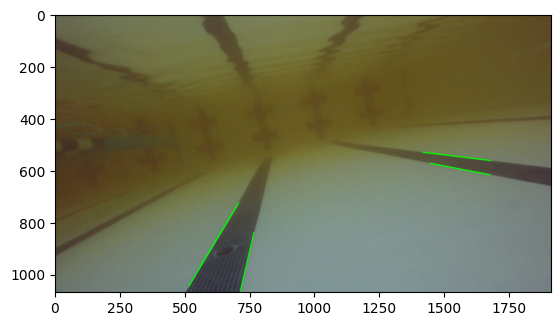

In [36]:
plt.imshow(draw_lanes(poolthing, myLanes))